# Multi objective optimization post-processing analysis

In [1]:
using Revise
using FUSE
using JLD2
using Plots;
gr();

# Process data

## Choose run directory

In [2]:
gen = 400

gen_path = "study_4/opt_distributed_baseline/gen_runs2/"

run_path = "study_4/opt_distributed_baseline/opt_runs2/"


"study_4/opt_distributed_baseline/opt_runs2/"

## Load ini params from run dir

In [3]:
cache_path = run_path
all_dirs = filter(isdir, sort(readdir(cache_path; join=true)))
println(length(all_dirs))

dirs = sort(filter(x -> !isfile(joinpath(x, "error.txt")) && split(x,"/")[end][1:2]==string(gen), all_dirs))
println(length(dirs))

inis = Dict()
ini_params = ["R0", "B0", "Ip", "P0", "fGW","dir"]

for param in ini_params
    inis[param] = []
end

for dir in dirs
    dd, ini, act = FUSE.load(dir; load_dd=false)

    R0 = ini.equilibrium.R0
    B0 = ini.equilibrium.B0
    Ip = ini.equilibrium.ip
    P0 = ini.equilibrium.pressure_core
    fGW = ini.core_profiles.greenwald_fraction

    inis["R0"] = [inis["R0"]; R0]
    inis["B0"] = [inis["B0"]; B0]
    inis["Ip"] = [inis["Ip"]; Ip]
    inis["P0"] = [inis["P0"]; P0]
    inis["fGW"] = [inis["fGW"]; fGW]
    inis["dir"] = [inis["dir"]; dir]

end



25471


0


## Load run results from cache

In [4]:
IMAS.update_ExtractFunctionsLibrary!(); # to pick up any ongoing development to extract function library

outputs = FUSE.extract(nothing; filter_invalid=:cols, cache=joinpath(gen_path, "extract.csv"), read_cache=true, write_cache=false);

┌ Info: Loaded cache file with 64 results
└ @ FUSE /home/weisbergd/julia_dev/FUSE/src/utils_end.jl:54


## New derived quantities

In [5]:
n = length(outputs[:,1])
outputs[:, "run"] = 1:n

outputs[:,"nGW"] = @. outputs[:,"ip"]/(π * (outputs[:,"a"])^2)*1e20
outputs[:,"fGW_ped"] = @. outputs[:,"ne_ped"]/outputs[:,"nGW"]
outputs[:,"fLH"] = @. outputs[:,"Psol"] / outputs[:,"PLH"];
outputs[:,"accessEC"] = @. 89.9 * (outputs[:,"ne0"]/1e20)^0.5 / (28.0 * outputs[:,"B0"]);


## Filter based on constraints

In [6]:
# Selection criterion
min_Pelectric = 200
min_fLH = 1.0
max_accessEC = 1
max_ds03 = 1.0
max_Sn = 1.5
max_qpol = 4.5e3
min_TF_j_margin = 1.5
min_OH_j_margin = 1.5
min_TF_stress_margin = 1.0
min_OH_stress_margin = 1.0

n = length(outputs[:,1])
index = 1:n
index = findall(
    (outputs[:, "Pelectric_net"] .> min_Pelectric) .&& 
    (outputs[:, "fLH"] .> min_fLH) .&& 
    (outputs[:, "accessEC"] .< max_accessEC) .&& 
    (outputs[:, "Hds03"] .< max_ds03) .&& 
    (outputs[:, "ne0/<ne>"] .< max_Sn) .&& 
    (outputs[:, "qpol"] .< max_qpol) .&&
    (outputs[:, "TF_j_margin"] .> min_TF_j_margin) .&&
    (outputs[:, "OH_j_margin"] .> min_OH_j_margin) .&&
    (outputs[:, "TF_stress_margin"] .> min_TF_stress_margin) .&&
    (outputs[:, "OH_stress_margin"] .> min_OH_stress_margin) )

println("$(n) valid runs")
println("$(length(index)) filtered points")

64 valid runs
64 filtered points


# Visualize data

## Plot evolution of key scalar quantities

In [7]:
# option to filter based on single parameter
if false
    t = outputs[:, "Hds03"]
    max_t = 0.95
    n = length(outputs[:,1])
    r = 1:n
    r = findall(t .< max_t)
# otherwise, either show whole dataset or fully-filtered subset    
else
    #r = index
    r = 1:n
end

N = length(outputs[r, "Pelectric_net"])

X = LinRange(1, N, 50)

import Statistics
function y_auto_range(y; σ=5, N=50)
    y_nonan = y[@. !isnan.(y)]
    m = Statistics.median(y_nonan)
    s = Statistics.median(Statistics.median(abs.(y_nonan .- m))) * σ
    Y = LinRange(max(m - s, minimum(y_nonan)), min(m + s, maximum(y_nonan)), N)
end

clim = missing

missing

### plot typical inputs

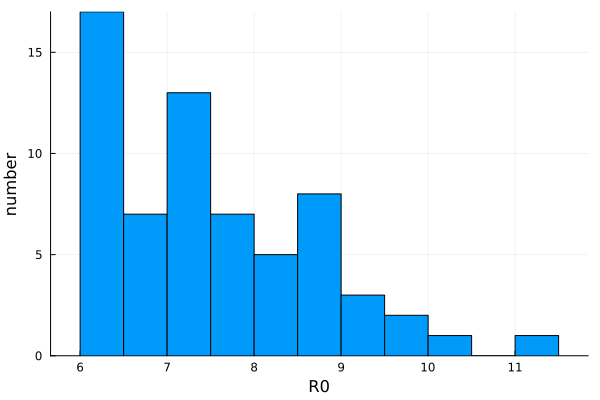

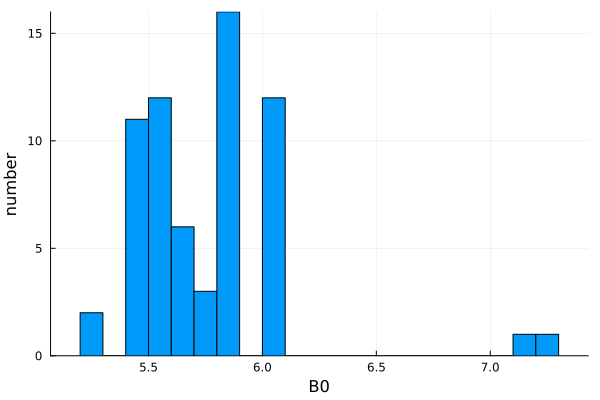

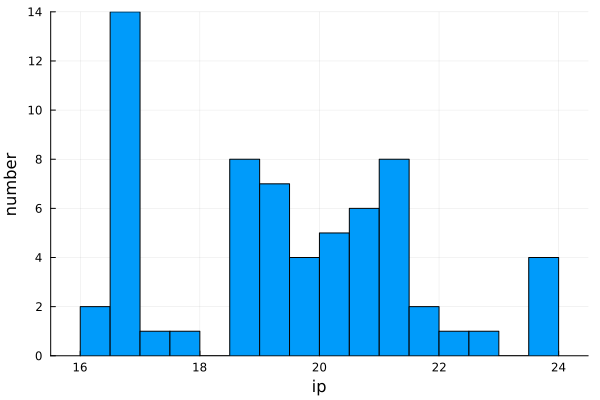

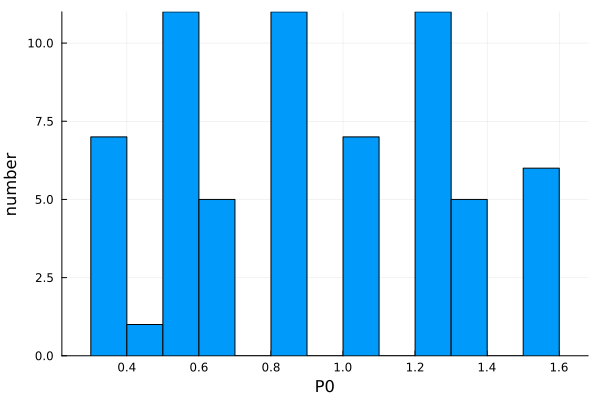

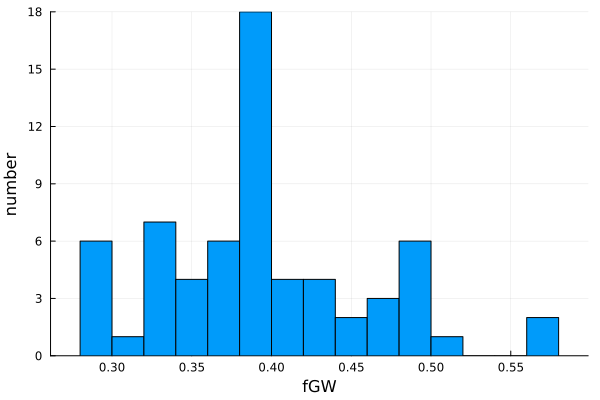

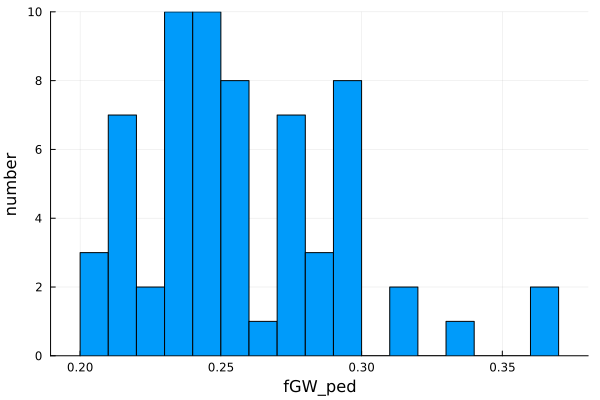

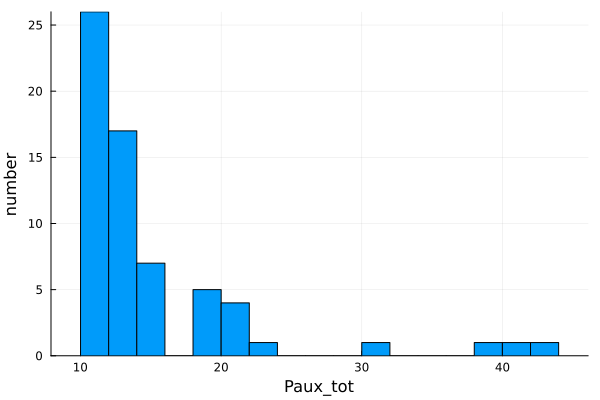

In [8]:
vars = ["R0", "B0", "ip", "P0", "fGW", "fGW_ped", "Paux_tot"]

for var in vars

    y = outputs[r, var]
    yname = var
    p = histogram(y, bins=20, ylabel="number", xlabel=yname, label="")
    display(p)

end


### plot typical objective functions

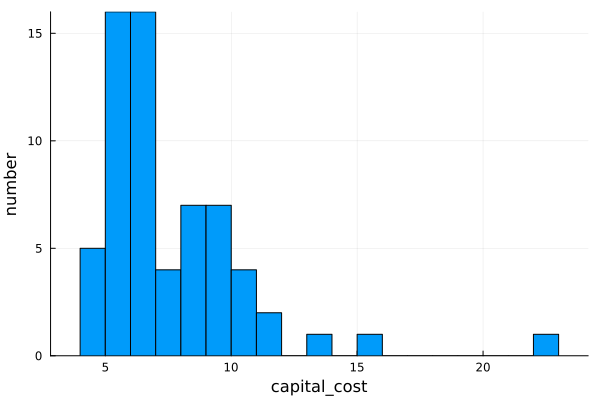

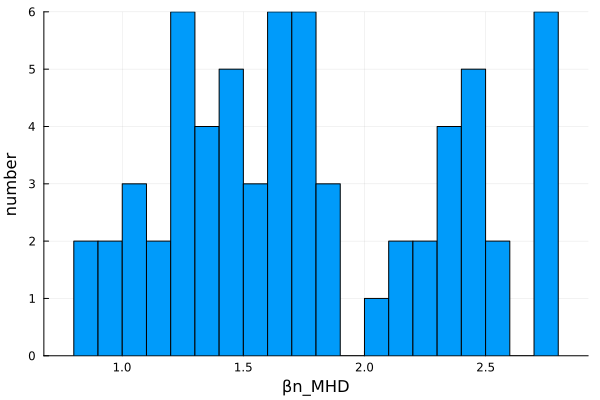

In [9]:
vars = ["capital_cost", "βn_MHD"]

for var in vars

    y = outputs[r, var]
    yname = var
    p = histogram(y, bins=20, ylabel="number", xlabel=yname, label="")
    display(p)

end


### plot typical output constraints

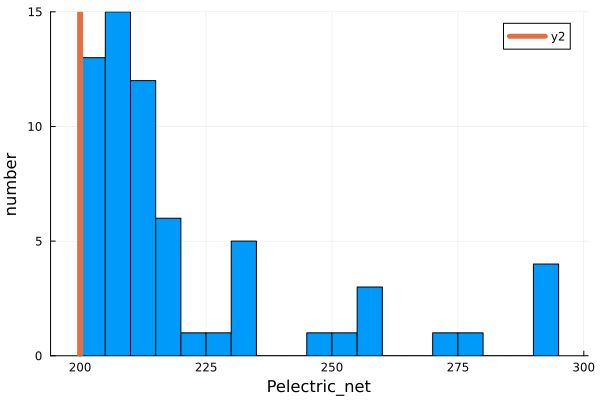

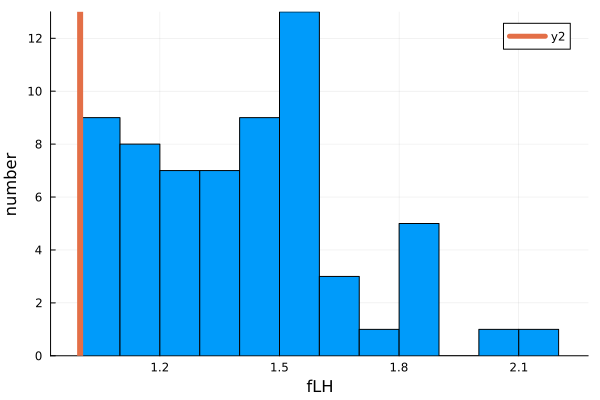

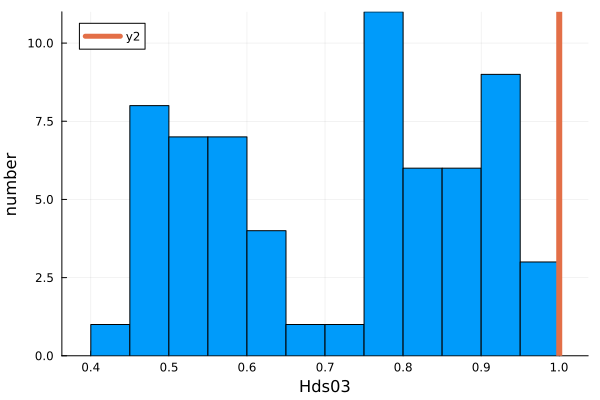

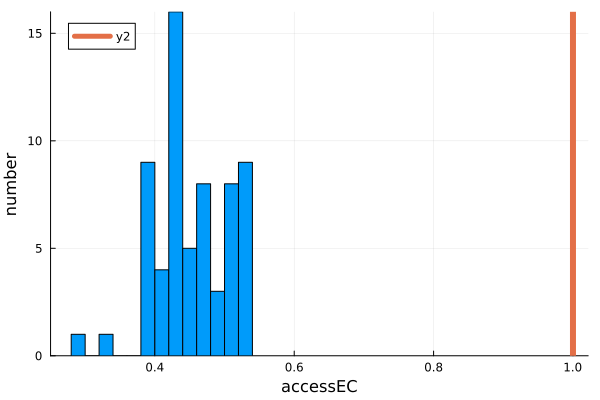

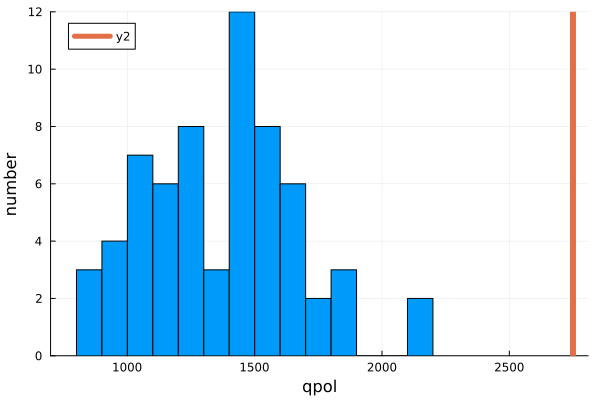

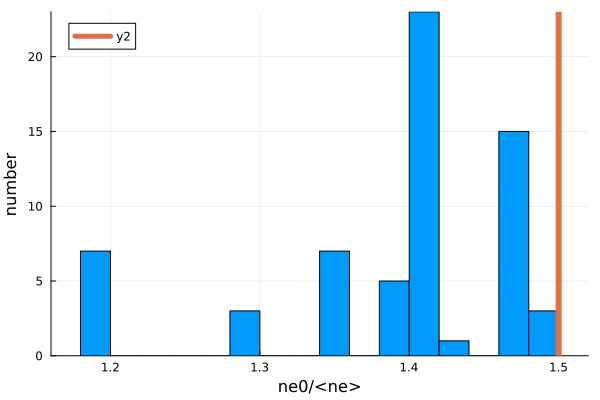

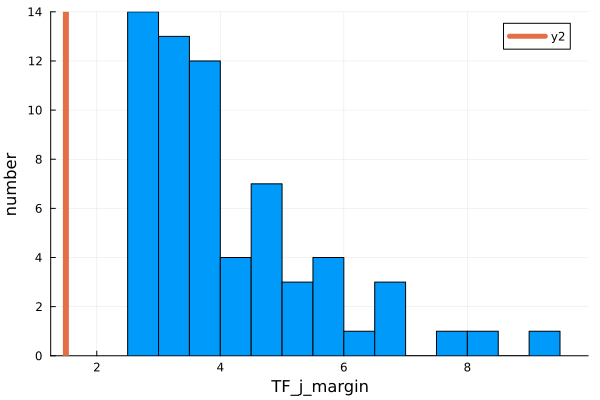

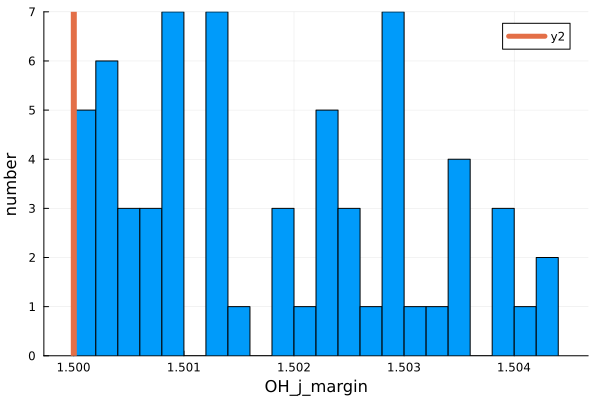

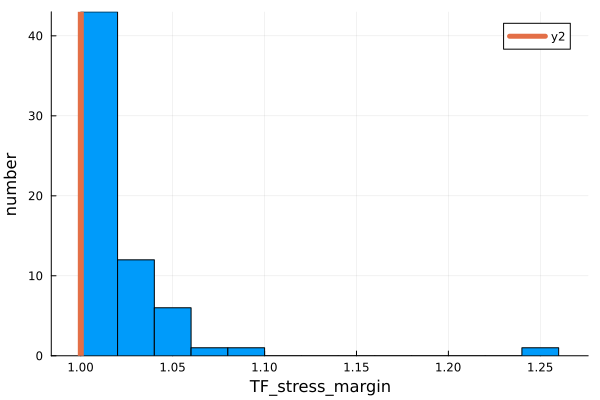

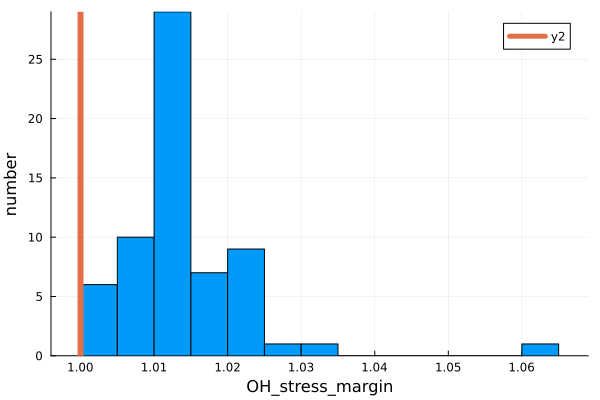

In [10]:
vars = ["Pelectric_net", "fLH", "Hds03", "accessEC", "qpol", "ne0/<ne>", "TF_j_margin", "OH_j_margin", "TF_stress_margin", "OH_stress_margin"]
constraints = [200, 1.0, 1.0, 1.0, 2.75e3, 1.5, 1.5, 1.5, 1.0, 1.0]

for (var, constraint) in zip(vars, constraints)

    y = outputs[r, var]
    yname = var
    p = histogram(y, bins=20, ylabel="number", xlabel=yname, label="")
    vline!(p, [constraint], lw=6)
    display(p)
end


### plot other informative outputs

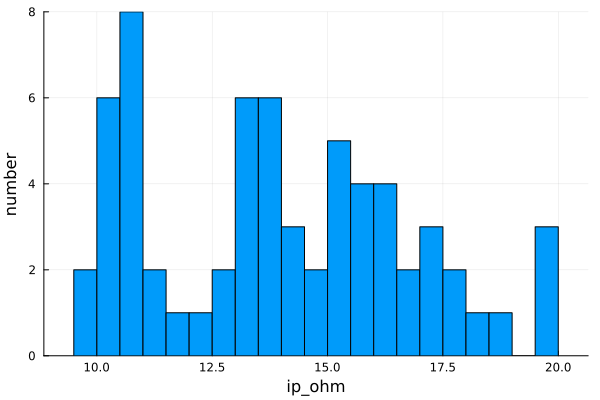

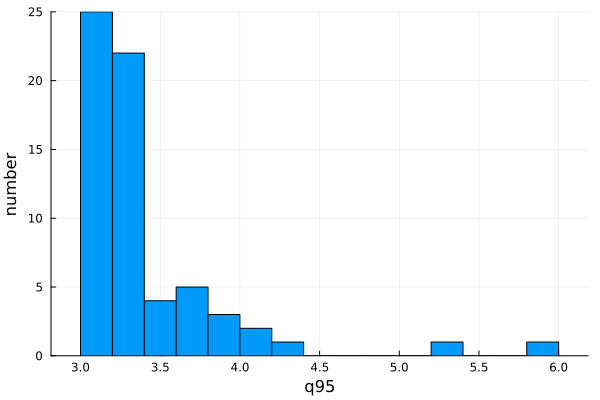

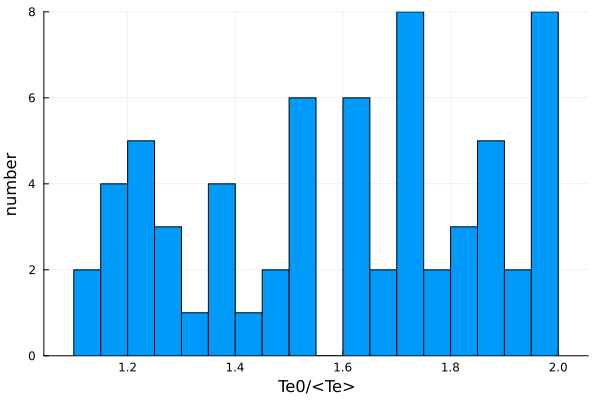

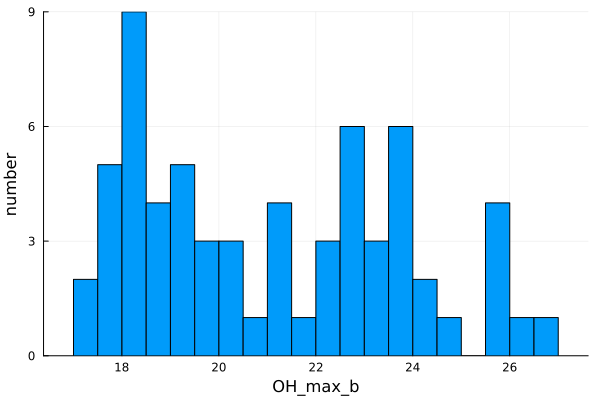

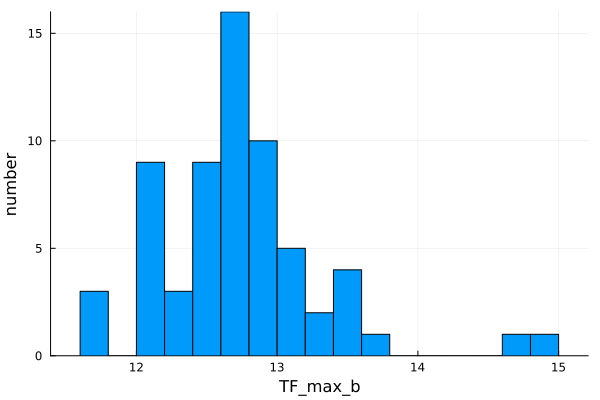

In [11]:
vars = ["ip_ohm","q95","Te0/<Te>","OH_max_b","TF_max_b"]

for (var, constraint) in zip(vars, constraints)

    y = outputs[r, var]
    yname = var
    p = histogram(y, bins=20, ylabel="number", xlabel=yname, label="")
    display(p)

end

## Plot in optimization space

61


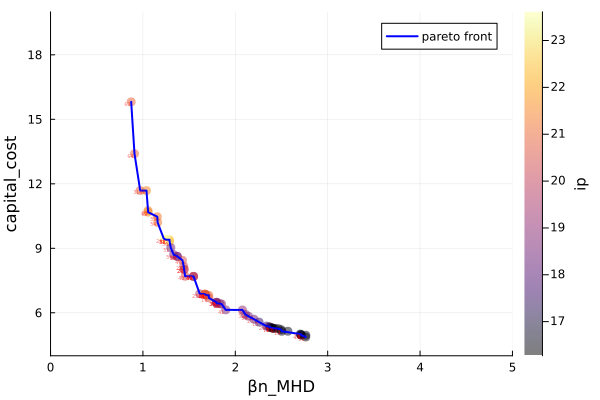

[63, 64, 31, 46, 60, 62, 55, 54, 29, 57, 58, 61, 42, 50, 51, 56, 28, 52, 47, 22, 23, 24, 43, 48, 49, 53, 25, 12, 14, 39, 40, 45, 44, 16, 34, 35, 36, 7, 10, 30, 41, 3, 32, 33, 27, 15, 26, 5, 1, 17, 19, 20, 6, 18, 2, 13, 21, 9, 8, 11, 38]


In [18]:
gr()

# x axis
xname = "βn_MHD";
x = outputs[:, xname];

#xname="βpol"; x=outputs[:,xname]
#xname="Pec [MW]"; x=outputs[:,"Pec"]

# y axis
yname = "capital_cost";
#yname = "βpol_MHD"
#yname = "B0"
y = outputs[:, yname];
#yname="ip_bs/ip_bs_aux_ohm"; y=outputs[:,"ip_bs"]./outputs[:,"ip_bs_aux_ohm"];
#yname="Pec=R0*ne*ip_aux(5+zeff)/(Te*0.09)"; y= @. outputs[:,"<ne>"]/1E20*outputs[:,"R0"]*outputs[:,"ip_aux"]*(5.0+outputs[:,"<zeff>"])/(0.09*outputs[:,"<Te>"])

# color
cname="run"; c=outputs[:, "run"];clim=(-Inf,Inf);
#cname="log10(flattop)"; c=log10.(outputs[:,"flattop"]);clim=(-Inf,Inf);
#cname="flattop"; c=outputs[:,"flattop"];clim=(-Inf,Inf);
#cname="Pelectric_net"; c=outputs[:,cname];clim=(200,300);
#cname="Ip aux [MA]"; c=outputs[:,"ip_aux"];clim=(-Inf,Inf);
#cname="fGW"; c=outputs[:,"fGW"];clim=(-Inf,Inf);
#cname="<zeff>"; c=outputs[:,"<zeff>"];clim=(-Inf,Inf);
#cname="R0 [m]"; c=outputs[:,"R0"];clim=(-Inf,8);
#cname="B0 [T]"; c=outputs[:,"B0"];clim=(-Inf,Inf);
#cname="B0*R0 [T*m]"; c=outputs[:,"B0"].*outputs[:,"R0"];clim=(-Inf,Inf);
#cname="ip_ohm"; c=outputs[:,cname];clim=(-Inf,Inf);
cname="ip"; c=outputs[:,cname];clim=(-Inf,Inf);
#cname = "q95"; c = outputs[:, cname]; clim = (-Inf, Inf);
#cname = "1/ϵ"; c = outputs[:, "R0"]./outputs[:, "a"]; clim = (-Inf, Inf);
#cname="Pec [MW]"; c=outputs[:,"Pec"];clim=(-Inf,Inf);
#cname="ip_bs_aux_ohm/ip"; c=outputs[:,"ip_bs_aux_ohm"]./outputs[:,"ip"];clim=(-Inf,Inf);
#cname="ip_ohm"; c=abs.(outputs[:,"ip_ohm"]);clim=(-Inf,Inf);
#cname="ip_bs_aux_ohm/ip"; c=outputs[:,"ip_bs_aux_ohm"]./outputs[:,"ip"];clim=(-Inf,Inf);
#cname="Ip aux [MA]"; c=outputs[:,"ip_aux"];clim=(-Inf,Inf);
#cname="qpol [MW/m^2]"; c=outputs[:,"qpol"];clim=(-Inf,2.75e3);
#cname="fLH"; c=outputs[:,"fLH"];clim=(-Inf,2);
#cname="βn_th"; c=outputs[:,"βn_th"];clim=(-Inf,5);

#cname="HTS"; c=(outputs[:,"TF_material"].=="ReBCO").+(outputs[:,"OH_material"].=="ReBCO").*2.0; clim=(0,4)

    
P = scatter(x, y, marker_z=c, xlabel=xname, ylabel=yname, colorbar_title=cname, marker=:circle,
    markersize=5, markerstrokewidth=0, label="", clim=clim, alpha=0.5,
    )



# Pareto front
if yname == "capital_cost"
    pindex = FUSE.pareto_front([[x[k], y[k]] for k in 1:length(x)])
    sort!(pindex, by=i -> y[i])
    sort!(pindex, by=i -> x[i])
    println(length(pindex))
    println(pindex)
    pannot = map(x -> ("\n$x", :right, 3, "courier", :red), pindex)
    plot!(P, x[pindex], y[pindex], series_annotations=pannot, color=:blue, label="pareto front", lw=2);
    #plot!(P, x[pindex], y[pindex], color=:blue, label="pareto front", lw=2);
else
    annot = map(x -> ("\n$x", :right, 8, "courier", :red), index)
    scatter!(P, x[index], y[index], series_annotations=annot, marker=:circle, alpha = 1.0);
end

plot!(P,xrange=(0,5),yrange=(4,20))

display(P)

## 1D plots of Pareto solutions

In [13]:
xname = "βn_MHD" 
yname_list = ["R0","B0","ip","Pfusion","Pelectric_net","fGW","Pec","qpol","Hds03"]

for yname in yname_list 
    P = scatter(outputs[pindex,xname], outputs[pindex,yname], xlabel=xname, ylabel=yname,marker=:circle,
    markersize=5, markerstrokewidth=0, lw=1, label="")
    display(P)
end

UndefVarError: UndefVarError: `pindex` not defined

## Plot correlation between parameters

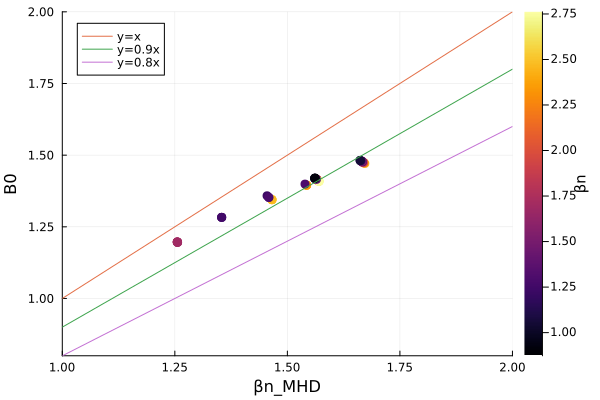

In [14]:
x = outputs[index, "fGW"] ./ outputs[index, "fGW_ped"]
y = outputs[index, "ne0"] ./ outputs[index, "<ne>"]

c = outputs[index, "βn"]; cname = "βn"; clim = (-Inf, Inf)
#c = outputs[index, "Pfusion"]; cname = "Pfusion"; clim = (-Inf, Inf)

P = scatter(x, y, marker_z=c, colorbar_title=cname, marker=:circle,
    markersize=5, markerstrokewidth=0, label="", clim=clim, alpha=1.0, z_order=:back,
    xlabel = xname, ylabel=yname,
    xlim = (1,2), ylim = (0.8,2))

xl = LinRange(0,2,100)

plot!(P, xl, xl.*1, label="y=x")
plot!(P, xl, xl.*0.9, label="y=0.9x")
plot!(P, xl, xl.*0.8, label="y=0.8x")

display(P)


## Plot digest for single case

/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_4/opt_distributed_baseline/gen_runs2/1__2023-11-17T23:39:23.845__3883826


┌ Error: reading ini.nbi.beam_energy : TypeError(:setfield!, "", Union{Missing, Float64, Function, Vector{Float64}}, Any[])
└ @ SimulationParameters /home/weisbergd/.julia/dev/SimulationParameters/src/io.jl:101


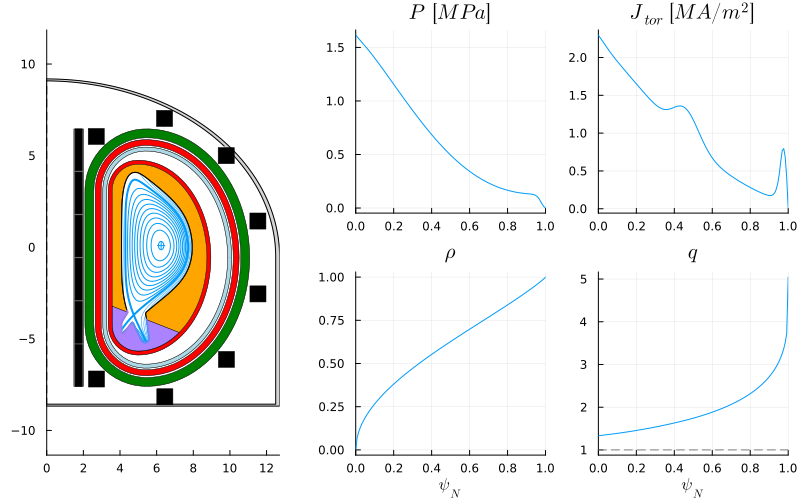

GEOMETRY                        EQUILIBRIUM                     TEMPERATURES                    DENSITIES                       
────────────────────────────    ────────────────────────────    ────────────────────────────    ────────────────────────────    
R0 → 6.01 [m]                   B0 → 5.44 [T]                   Te0 → 53.2 [keV]                ne0 → 8.29e+19 [m⁻³]            
a → 1.72 [m]                    ip → 16.5 [MA]                  Ti0 → 43.9 [keV]                ne_ped → 4.31e+19 [m⁻³]         
1/ϵ → 3.5                       q95 → 3.06                      <Te> → 26.9 [keV]               <ne> → 5.88e+19 [m⁻³]           
κ → 2.15                        <Bpol> → 1.15 [T]               <Ti> → 23.5 [keV]               ne0/<ne> → 1.41                 
δ → 0.712                       βpol_MHD → 1.02                 Te0/<Te> → 1.98                 fGW → 0.378                     
ζ → -0.101                      βtor_MHD → 0.0489               Ti0/<Ti> → 1.87                 z

24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume    
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.48478     0.0       1.48478                20.8599      97.3025
   2 │ in                  oh        0.515044    1.48478   1.99982  ReBCO          7.23593     79.2132
   3 │ in                            0.0858566   1.99982   2.08568                 1.20621     15.4817
   4 │ hfs                 tf        0.483753    2.08568   2.56943  ReBCO         17.5568     283.44
   5 │ hfs                           0.0858566   2.56943   2.65529                 3.1645     125.781
   6 │ hfs     low temp    shield    0.318252    2.65529   2.97354  Steel         10.5652     409.377
   7 │ hfs                           0.0858566   2.97354   

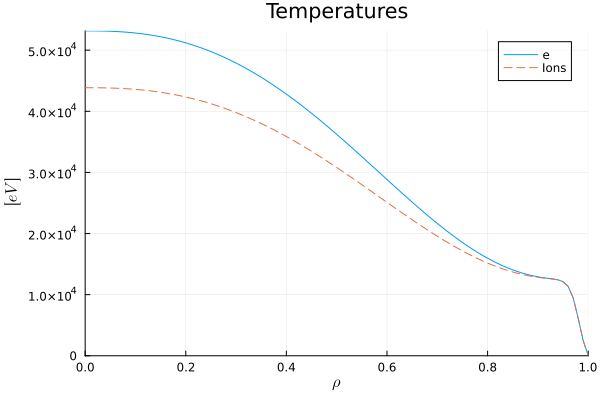

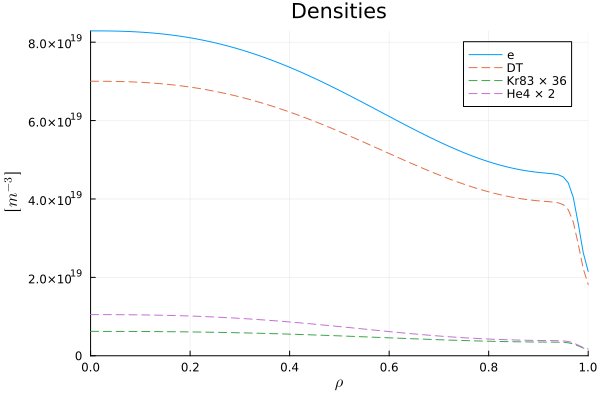

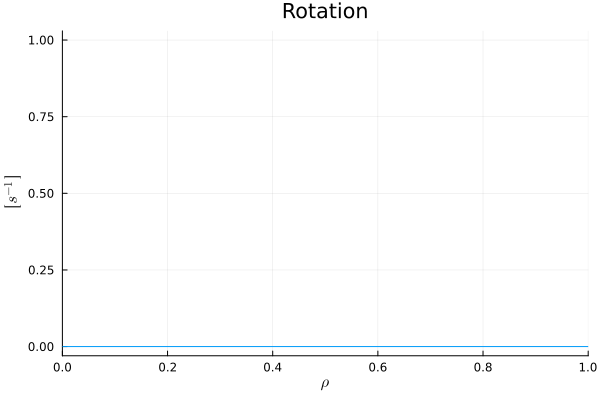

​
​
​
​


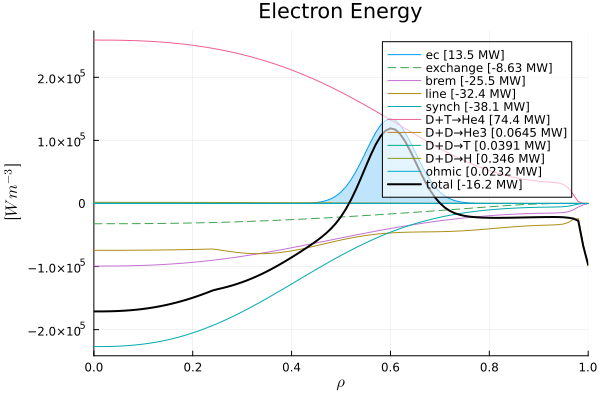

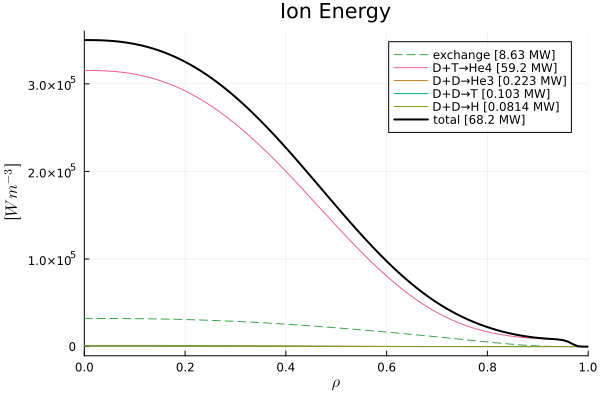

​
​


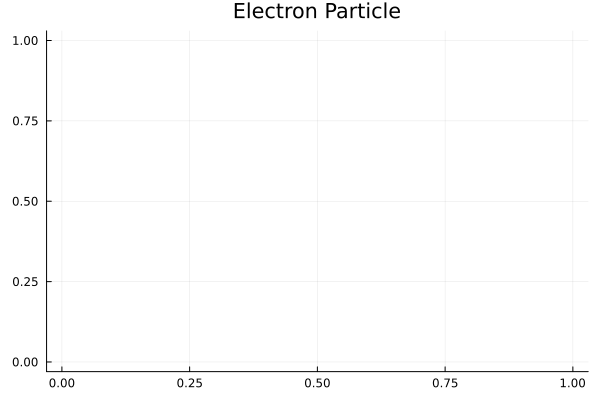

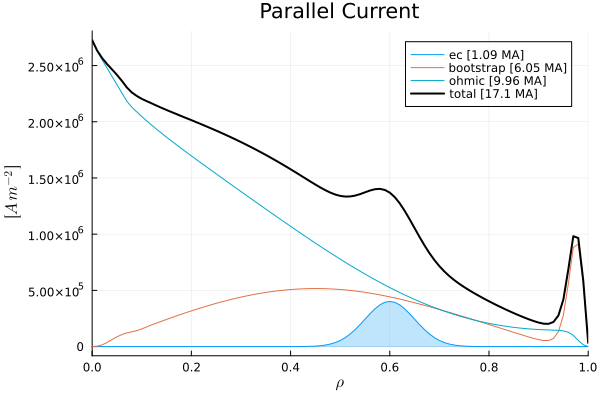

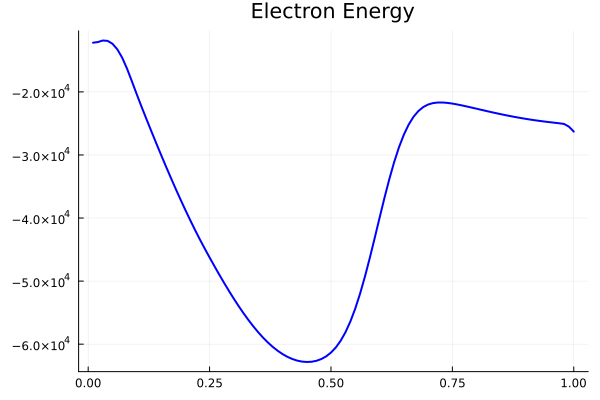

​
​
​


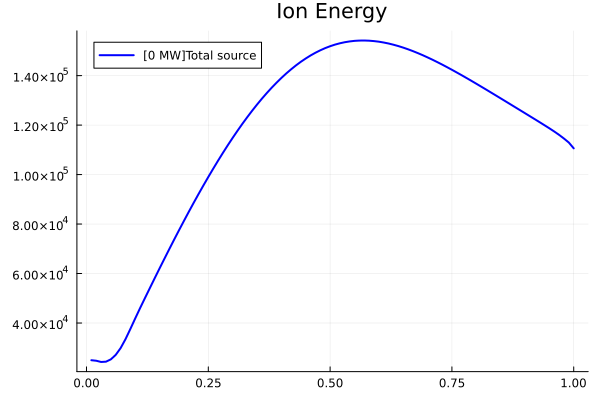

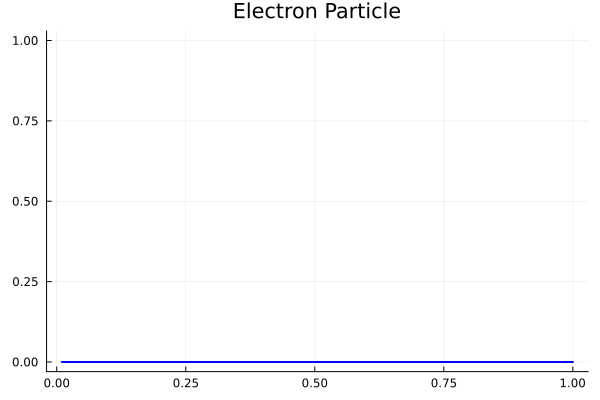

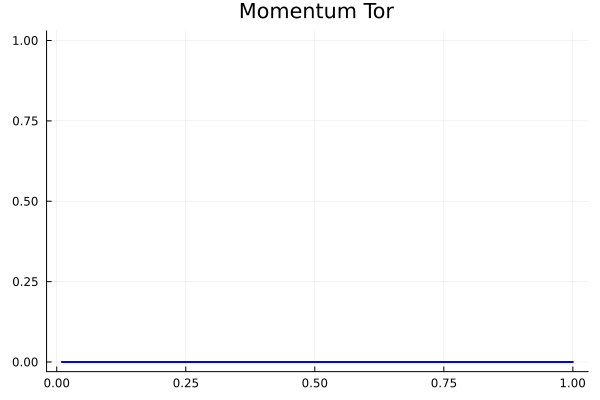

​
​
​


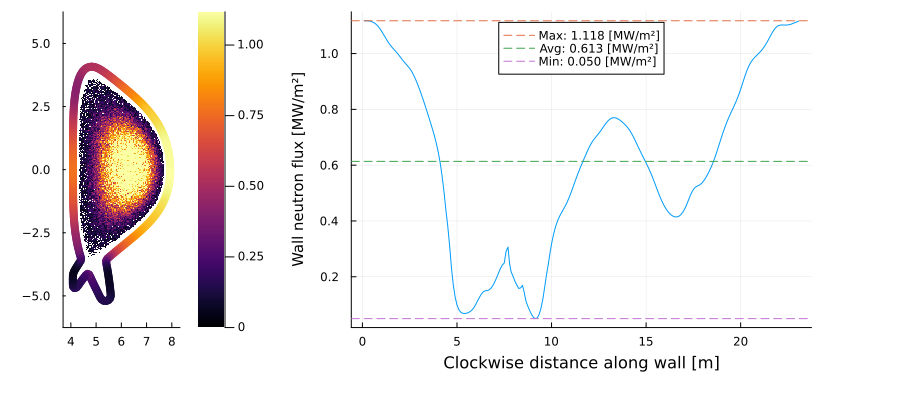

​


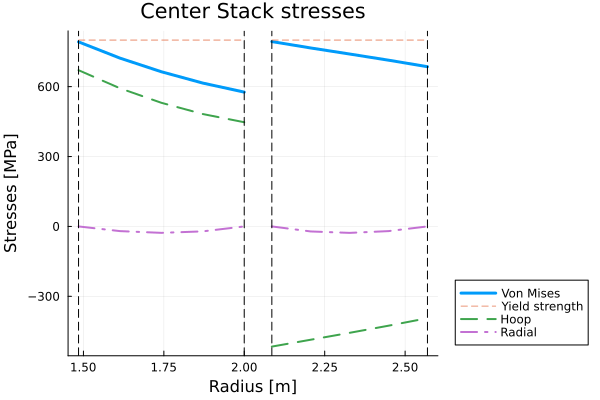

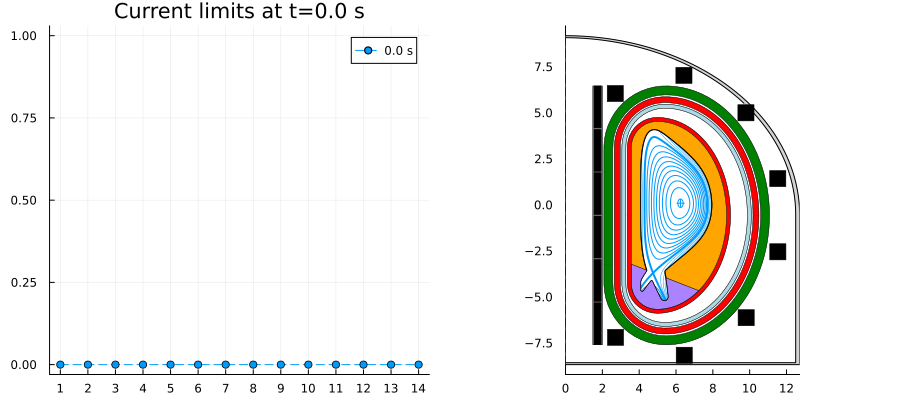

​
​


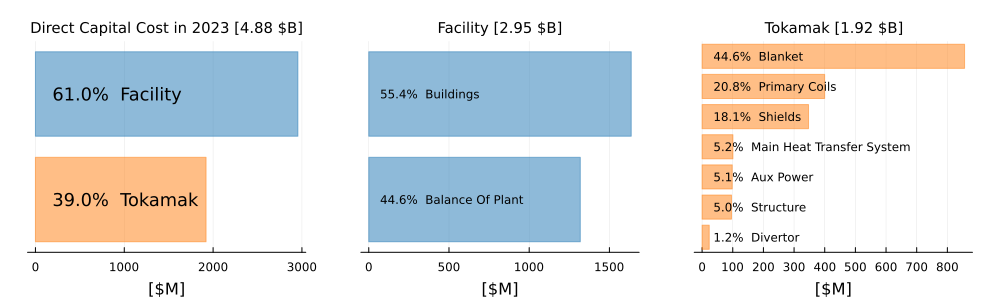

​
dir = "/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_4/opt_distributed_baseline/gen_runs2/1__2023-11-17T23:39:23.845__3883826"


"/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/study_4/opt_distributed_baseline/gen_runs2/1__2023-11-17T23:39:23.845__3883826"

In [19]:
n = 38
dir = outputs[n, "dir"]
#n=length(dirs)
println(dir)
dd, ini, act = FUSE.load(dir)
FUSE.digest(dd)
@show dir